In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os, sys
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, log_loss, roc_curve, auc, confusion_matrix
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping

# Analyze data

In [10]:
train_dir = "./dataset/train"
test_dir = "./dataset/test/"

In [11]:
# See data stats
skin = os.listdir(train_dir)
num_train = {}

for d in skin:
    if not d == '.DS_Store':
        num_train[d] = len(os.listdir(train_dir + '/' + d))

img_per_class_train = pd.DataFrame(num_train.values(), index=num_train.keys(), columns=["No. of images"])

img_per_class_train

,No. of images
malignant,4605
benign,5000


<Axes: title={'center': 'Train distribution by disease'}, xlabel='Skin cancer classification', ylabel='Number of images'>

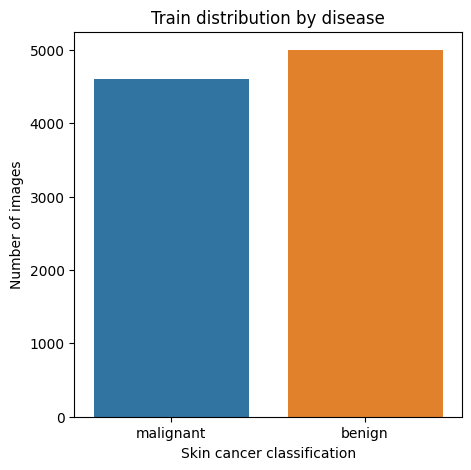

In [12]:
# Plot distribution
plt.figure(figsize=(5,5))

plt.title("Train distribution by disease")
plt.ylabel("Number of images")
plt.xlabel("Skin cancer classification")

keys = list(num_train.keys())
vals = list(num_train.values())

sns.barplot(x=keys, y=vals)

# See data

In [13]:
batch_size = 32
img_height = 300
img_width = 300

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


class_names = train_ds.class_names

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9605 files belonging to 2 classes.
Using 7684 files for training.
Found 9605 files belonging to 2 classes.
Using 1921 files for validation.
Found 1000 files belonging to 2 classes.


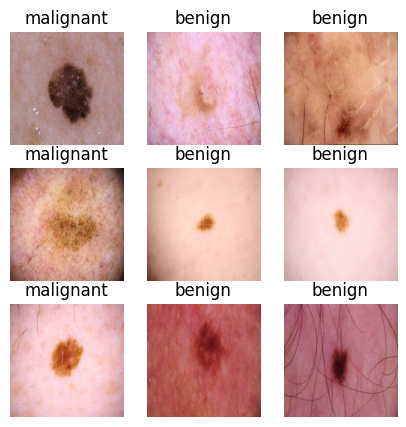

In [14]:
# Show images

plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Normalize data

In [15]:
# To standarize RGB values from 0-255 to 0-1
# This layer will be used directly in the model
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Optimize dataset for performence

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data Augmentation

In [17]:
data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2)
])

# Create model

In [33]:
num_classes = len(class_names)

def base_model():
    """
    Model 1: Basic model
    ---------------------
    - A simple CNN with 3 convolutional blocks followed by two dense layers.
    """
    return tf.keras.Sequential([
        normalization_layer,
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes)
    ])

def model_with_data_augmentation(model):
    """
    Model 2: Base + Data Augmentation
    ---------------------------------
    - Builds upon Model 1 by prepending a data augmentation layer.
    """
    layers = [data_augmentation] + model.layers
    return tf.keras.Sequential(layers)

def model_with_extra_layers():
    """
    Model 3: Base + Data Augmentation + Additional Layers
    -----------------------------------------------------
    - Builds upon Model 2 by adding:
      - Leaky ReLU activations
      - Batch normalization
      - A larger convolutional layer
      - Global average pooling
    """
    return tf.keras.Sequential([
        data_augmentation,
        normalization_layer,
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, (3,3), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.1),
        tf.keras.layers.Conv2D(32, (3,3), padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(alpha=0.1),
        tf.keras.layers.Conv2D(64, (5,5), padding="same", activation="relu"),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes)
    ])


### Build model and choose epochs

In [31]:
epochs = 50
model_num = 3

if model_num == 1:
    model = base_model()
elif model_num == 2:
    model = model_with_data_augmentation(base_model())
elif model_num == 3:
    model = model_with_extra_layers()

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Run model

In [227]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=10)

history = model.fit(

  
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop])

Epoch 1/50
241/241 [==============================] - 2465s 10s/step - loss: 0.4174 - accuracy: 0.8054 - val_loss: 0.3470 - val_accuracy: 0.8631
Epoch 2/50
241/241 [==============================] - 960s 4s/step - loss: 0.3083 - accuracy: 0.8658 - val_loss: 0.2969 - val_accuracy: 0.8777
Epoch 3/50
241/241 [==============================] - 701s 3s/step - loss: 0.2695 - accuracy: 0.8876 - val_loss: 0.2884 - val_accuracy: 0.8792
Epoch 4/50
241/241 [==============================] - 704s 3s/step - loss: 0.2504 - accuracy: 0.8952 - val_loss: 0.2578 - val_accuracy: 0.8964
Epoch 5/50
241/241 [==============================] - 705s 3s/step - loss: 0.2407 - accuracy: 0.9011 - val_loss: 0.2660 - val_accuracy: 0.8886
Epoch 6/50
241/241 [==============================] - 701s 3s/step - loss: 0.2248 - accuracy: 0.9081 - val_loss: 0.2583 - val_accuracy: 0.8964
Epoch 7/50
241/241 [==============================] - 718s 3s/step - loss: 0.2151 - accuracy: 0.9135 - val_loss: 0.2605 - val_accuracy: 0.89

In [228]:
epochs_executed = len(history.history['loss'])


filename = 'graphs/Model ' + str(model_num) + '/model_summary.txt'

# Check if the file already exists
if not os.path.exists(filename):
    with open(filename, 'w') as f:
        original_stdout = sys.stdout
        sys.stdout = f
        
        model.summary()
        
        sys.stdout = original_stdout
else:
    print(f"File '{filename}' already exists. Not overwriting.")

File 'graphs/Model 1/model_summary.txt' already exists. Not overwriting.


# Validate model

In [229]:
if (epochs_executed != epochs):
    graph_dir = 'graphs/Model ' + str(model_num) + '/' + str(epochs_executed) + ' (' + str(epochs) + ') epochs/'
else:
    graph_dir = 'graphs/Model ' + str(model_num) + '/' + str(epochs_executed) + ' epochs/'

if not os.path.exists(graph_dir):
    os.makedirs(graph_dir)

## Accuracy and Loss

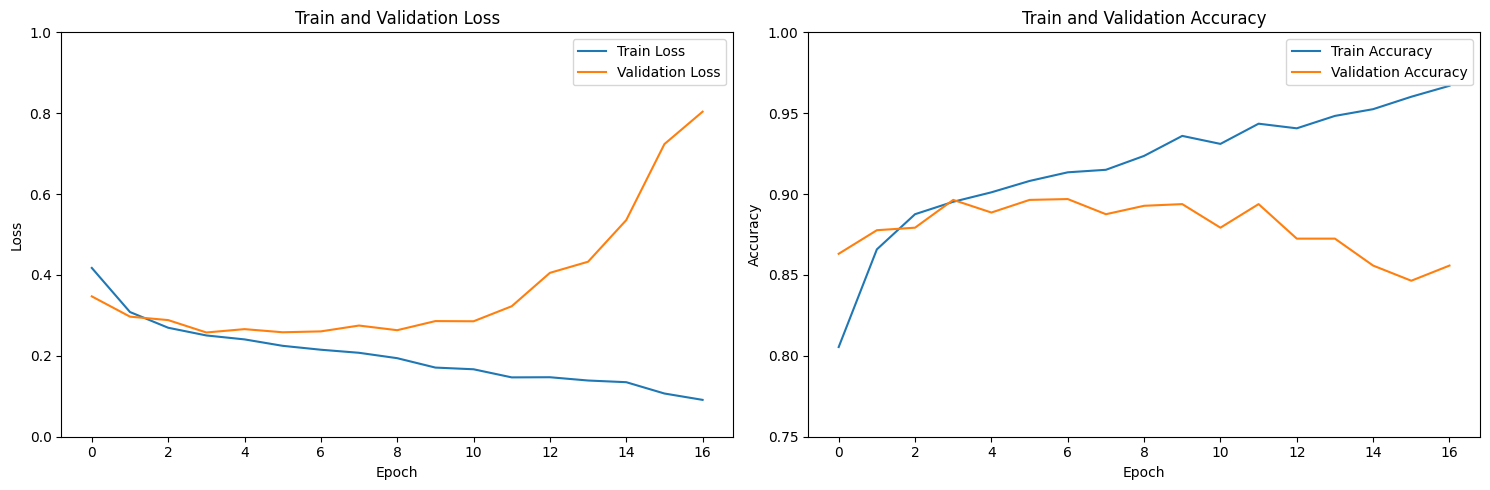

In [230]:
epochs_range = range(epochs_executed)

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(epochs_range, history.history['loss'],label="Train Loss")
plt.plot(epochs_range, history.history['val_loss'], label="Validation Loss")
plt.ylim(0.0,1.0)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(epochs_range, history.history['accuracy'], label="Train Accuracy")
plt.plot(epochs_range, history.history['val_accuracy'], label="Validation Accuracy")
plt.ylim(0.75,1.0)
plt.legend()
plt.savefig(graph_dir + 'accuracy.png')
plt.tight_layout()

In [231]:
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation loss: {val_loss:.4f}")

61/61 [==============================] - 47s 771ms/step - loss: 0.8038 - accuracy: 0.8558
Validation accuracy: 85.58%
Validation loss: 0.8038


## F1 score, Recall and Log loss

In [232]:
# Convert logits to probabilities
y_pred_probs = tf.nn.softmax(model.predict(val_ds)).numpy()

# Get the class with the highest probability as predicted class
y_pred = np.argmax(y_pred_probs, axis=1)

# Extract true labels from the validation dataset
y_true = []
for _, labels in val_ds:
    y_true.extend(labels.numpy())

y_true = np.array(y_true)

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')  # 'weighted' can be replaced with 'micro', 'macro', etc. depending on the needs

# Calculate recall
recall = recall_score(y_true, y_pred, average='weighted')  # similarly, 'weighted' can be replaced

# Calculate log loss
loss = log_loss(y_true, y_pred_probs)

print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Log Loss: {loss:.4f}")


61/61 [==============================] - 48s 744ms/step
F1 Score: 0.8534
Recall: 0.8558
Log Loss: 0.7783


# ROC & AUC

In [233]:
# Extract true labels from the validation dataset
y_true = []
for _, labels in val_ds:
    y_true.extend(labels.numpy())

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs[:,1])

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

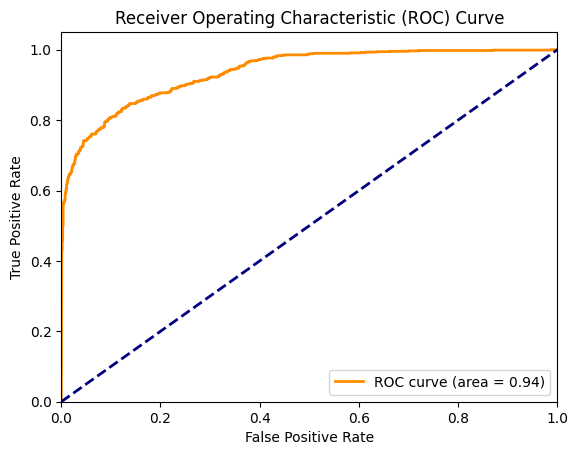

In [234]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig(graph_dir + 'ROC.png')
plt.show()

# Write to CSV

In [235]:
data_to_write = {
    'Model': model_num,
    'Epochs': epochs_executed,
    'Accuracy': val_accuracy,
    'Loss': val_loss,
    'F1 Score': f1,
    'Recall': recall,
    'Log loss': loss,
    'AUC': roc_auc
    
}
df_to_append = pd.DataFrame(data_to_write, index=[0]).round(3)

# Append/Create CSV
csv_file = 'results.csv'
if not os.path.isfile(csv_file):
    df_to_append.to_csv(csv_file, header=True, index=False)
else:
    df_to_append.to_csv(csv_file, mode='a', header=False, index=False)


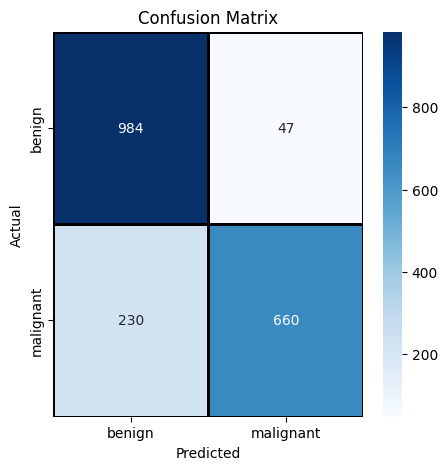

In [236]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, linecolor="black", linewidths=1, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.savefig(graph_dir + 'confusion.png')
    plt.show()

# Example usage:
# Assuming test_data.classes contains the true labels and y_pred contains the predicted labels
plot_confusion_matrix(y_true, y_pred, class_names)

# Plot the models

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='graphs/Model ' + str(model_num) + '/model.png', show_shapes=True, show_layer_names=True)